## W6. Time series forecasting.


In this task we will try to improve the results of the ARIMA and SARIMA models uploaded by our teacher. How are we going to do this? We are going to change the ARIMA and SARIMA parameters, trying to explain the reason of these changes, and compare our results with the previous ones. Let's start.

First, we have to import our file and read it using Pandas.

In [1]:
import numpy as np
import pandas as pd

filename = 'C:\\Users\\Rafa\Desktop\\Master Big Data\\06. Descriptive Machine Learning\\W6. Time series forecasting\\AirPassengers.csv'

In [2]:
pd.read_csv(filename)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In the original CSV file there are two columns: one for each month along around twenty years, and the second one for the number of passengers who travel with an airline each month. First step is achieve that 'months' column works as index in our DataFrame.

In [3]:
from datetime import datetime

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(filepath_or_buffer = filename, parse_dates = ['Month'], index_col = 'Month', date_parser = dateparse)
print(data.head())
print('\n Data Types:')
print(data.dtypes)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

 Data Types:
#Passengers    int64
dtype: object


Now our DataFrame is ready to start working with it as time series.

We are going to plot data firstly, in order to see some trends.

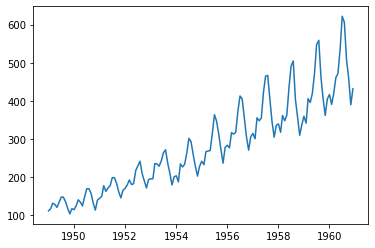

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.plot(data)
plt.show()

It is obvious that every year the number of passengers raises. This is the main trend. Because of this, we can assure that the plot increases temporarily. We are going to zoom in twelve first data to analyse the trend around one year.

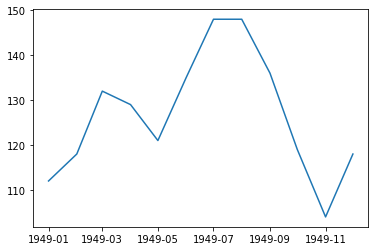

In [5]:
plt.plot(data.head(12))
plt.show()

In the above plot we can see in a clear way that the amount of passengers raises when the holidays are coming. The peak of the plot is in the summer months. Another certain trend is that after the summer the number of passengers decreases, and, as early as november comes, the total amount starts to increase again. Every year the trend is repeated. Therefore, we can assure that this time series has a seasonality trend.

Because of these reasons, it is obvious that the time series is not stationary. But we are going to verify it using the Augmented Dickey-Fuller test (ADF). The null hypotesis of this test is that time series is non-stationary. If p-value of the test is less than 0.05 (significance level), the hypotesis can be rejected and we can guarantee that the time series is stationary.

In [6]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data['#Passengers'])
print('p-value: ', dftest[1])

p-value:  0.9918802434376409


p-value is very close to 1, so the series is clearly non-stationary.

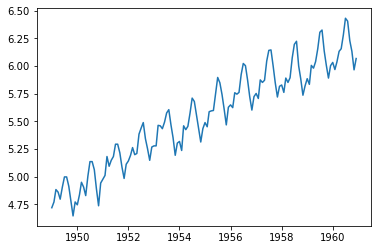

p-value:  0.4223667747703857


In [7]:
no_variance = np.log(data)

plt.plot(no_variance.dropna())
plt.show()

dftest = adfuller(no_variance.dropna())
print('p-value: ', dftest[1])

### ACF and PACF.
One of the most important concepts in time series is autocorrelation. Autocorrelation is an statistical term which describes the presence or absence of correlation in time series data. It indicates if past observations have some influence in the current ones. The autocorrelation function (ACF) tells you the correlation between points separated by various time lags.

On the other hand, the partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values.

When we are modeling time series, we are performing regression analysis on our data. Because of this, we need that these data has no autocorrelation or very close to 0.

We can import 'statsmodels' in order to graphic ACF and PACF plots and analyse the autocorrelation of our data.

Autocorrelation and partial autocorrelation plots are very useful to estimate the 'p' and 'q' parameters of an ARIMA model. The missing parameter 'd' is the minimum order of differencing of our time series to become it stationary.

To find out these parameters we are going to follow this rule:

* Model AR(p) if autocorrelation function decays exponentially and partial autocorrelation function is equal to 0 after 'p'.
* Model MA(q) if autocorrelation function is equal to 0 after 'q' and partial autocorrelation function decays exponentially.
* Model ARMA(p, q) if both autocorrelation function and partial autocorrelation function decay expoentially.

Before do that, we have to discover the optimal order of differencing.

### Identifying the order of differencing.
The order of differencing is the minimum difference value for which the series becomes stationary. Another definition about this is the following one (Duke University, https://people.duke.edu/~rnau/411arim2.htm):

"Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero, either from above or below"

We have proved before that the time series is non-stationary. So, if we have to transform this time series from non-stationary to stationary, we can reject 0 as order of differencing.

### Differencing our time series.
Differencing is a method of transforming a time series dataset. It can be used to remove the series dependence on time and includes structures like trends and seasonality. As we said before, it is evident that the data has a 12-months seasonality. Thus, we are going to start differencing the time series using a period of 12.

* Note: It is important to drop the null values of the series in order to calculate the p-value using ADF (we have used dropna).

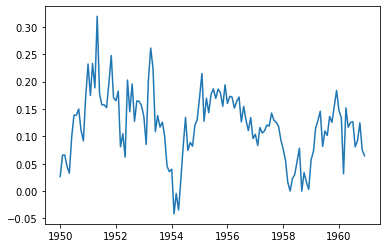

p-value:  0.07239567181769463


In [8]:
data['seasonal_difference'] = no_variance['#Passengers'].diff(periods = 12)

plt.plot(data['seasonal_difference'])
plt.show()

dftest = adfuller(data['seasonal_difference'].dropna())
print('p-value: ', dftest[1])

Troubling p-value. We cannot confirm that our time series is already stationary. Maybe we will have to difference again. Let's display its ACF and PACF plots.

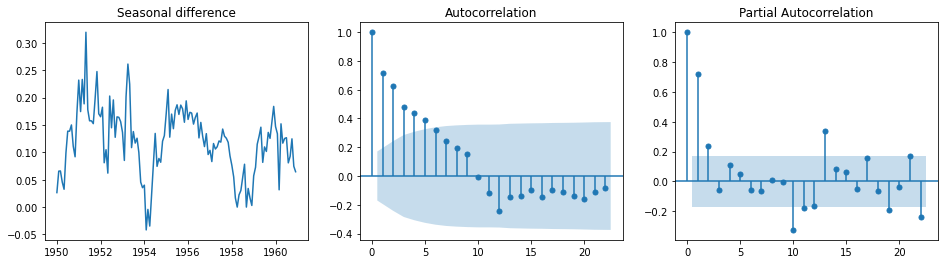

In [9]:
import statsmodels.api as sm

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))

ax1.plot(data['seasonal_difference'])
ax1.set_title('Seasonal difference')

sm.graphics.tsa.plot_acf(data['seasonal_difference'].dropna(), ax = ax2);
sm.graphics.tsa.plot_pacf(data['seasonal_difference'].dropna(), ax = ax3);

The autocorrelation plot has some positive lags which may imply underdifferencing. It is possible that another difference was needed. But first let's analyse these both plots deeply in order to get the possible parameters of our model.

Looking at the autocorrelation plot it is evident that the autocorrelation function decays exponentially to 0. And also, the partial autocorrelation function cut offs (becomes zero abruptly) after lag-2. For this two reasons, we can suggest that choose a AR(2) model might be a correct decision.

Later, we are going to use a SARIMA model in order to predict future values. A SARIMA model is an ARIMA model with a seasonal component. The parameters of a SARIMA model are 'P', 'D' and 'Q', the same as the ARIMA model but removing the seasonality from our time series.

We had removed the seasonality from our time series before when we differentiated our time series using a 12-months period, so we have just calculated the 'P', 'D' and 'Q' parameters for our SARIMA model, which are the following ones:

* P = 2 (PACF becomes 0 after lag-2)  
* D = 1 (We have differentiated the time series once)  
* Q = 0 (The best model is an AR(p), MA(q) term is 0)  

In other words, we are going to use (2, 1, 0, 12) as terms of SARIMA model afterwards.

But in order to use a SARIMA model, we need the 'p', 'd' and 'q' terms of the ARIMA part. The ARIMA part refers to the time series without removing the seasonality. So, we are going to calculate the first difference of the series and display the ACF and PACF plots to get a good approximation to the required parameters.

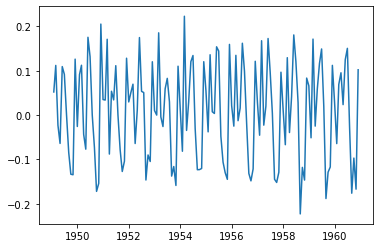

p-value:  0.0711205481508568


In [10]:
data['first_difference'] = no_variance['#Passengers'].diff(periods = 1)

plt.plot(data['first_difference'])
plt.show()

dftest = adfuller(data['first_difference'].dropna())
print('p-value: ', dftest[1])

We are in the boundary of the significance level again. Perhaps a new differencing might be a good idea, but we are going to try it later. Now, let's plot the ACF and PACF charts.

* Note: we can use the parameter 'lags' in order to expand the time label. For example, in the autocorrelation plot using a higher 'lags' value the seasonality of the series is shown in a clearer way.

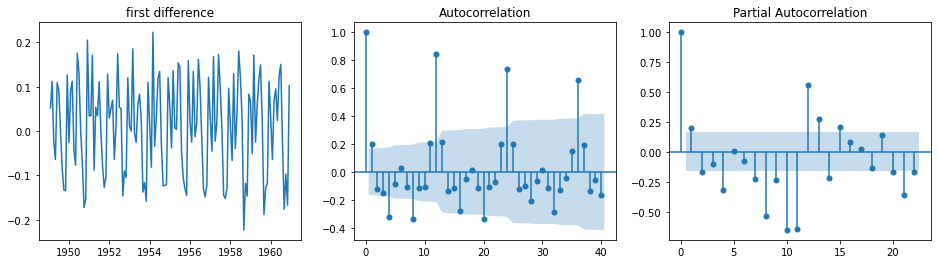

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))

ax1.plot(data['first_difference'])
ax1.set_title('first difference')

sm.graphics.tsa.plot_acf(data['first_difference'].dropna(), ax = ax2, lags = 40);
sm.graphics.tsa.plot_pacf(data['first_difference'].dropna(), ax = ax3);

Okey, let's remember the rule to get the ARIMA parameters:

* Model AR(p) if autocorrelation function decays exponentially and partial autocorrelation function is equal to 0 after 'p'.
* Model MA(q) if autocorrelation function is equal to 0 after 'q' and partial autocorrelation function decays exponentially.
* Model ARMA(p, q) if both autocorrelation function and partial autocorrelation function decay expoentially.

This case is not clear at all. We think that the partial autocorrelation function decays exponentially, although it is not very sharp. And the autocorrelation function seems that becomes to 0 after lag-, which involves a MA(1) model. Or maybe it fits in an ARMA(1, 1) model. We are not sure about it, so we prefer get a second order of differencing of the time series and then, have a look again in order to get the best parameters.

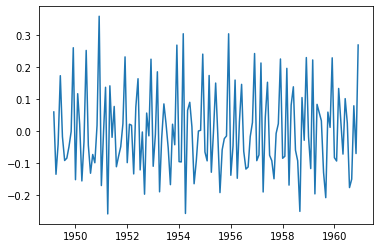

p-value:  7.419304549378255e-13


In [12]:
data['second_difference'] = data['first_difference'].diff(periods = 1)

plt.plot(data['second_difference'])
plt.show()

dftest = adfuller(data['second_difference'].dropna())
print('p-value: ', dftest[1])

Obviously, now our time series is stationary. Let's plot ACF and PACF.

C:\Users\Rafa\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


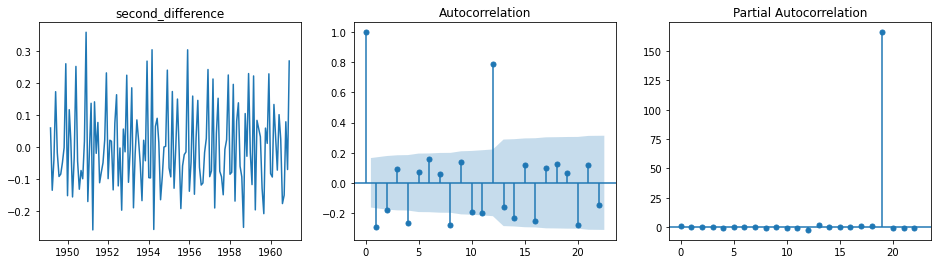

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))

ax1.plot(data['second_difference'])
ax1.set_title('second_difference')

sm.graphics.tsa.plot_acf(data['second_difference'].dropna(), ax = ax2);
sm.graphics.tsa.plot_pacf(data['second_difference'].dropna(), ax = ax3);

Here, the discovery of the parameters is much less clear than before. Now we get a lot of changes of sign in our ACF plot, which implies overdifferencing. Definitely, we prefer try with several of the previous models and compare the results.

### Conclusions.

Using the past analysis we have got the following two candidates:

* SARIMA: (0, 1, 1), (2, 1, 0, 12)
* SARIMA: (1, 1, 1), (2, 1, 0, 12)

### Optimizing results. 

The pmdarima Python module has a functionality that allows calculating the best SARIMA model using the min and max values for each parameter. We are going to install and use this library in order to get the optimal parameters. Note that we have use our original time series data without any modification (even without the variance removing).

In [14]:
from pmdarima.arima import AutoARIMA

arima_model = AutoARIMA(start_p = 0, d = None, start_q = 0, max_p = 4, max_d = 2, max_q = 4, 
                        start_P = 0, D = None, start_Q = 0, max_P = 4, max_D = 2, max_Q = 4, m = 12, seasonal = True,
                        max_order = 20, error_action = 'ignore')

In [15]:
arima_model.fit(data['#Passengers'])

AutoARIMA(error_action='ignore', m=12, max_D=2, max_P=4, max_Q=4, max_order=20,
          max_p=4, max_q=4, start_P=0, start_Q=0, start_p=0, start_q=0)

In [16]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Thu, 04 Mar 2021   AIC                           1019.178
Time:                                     17:14:52   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Wow! The best result is one of the two candidates that we have calculated before. Now, let's use the script of our professor to get the MSE and another measures of quality.

Note that we have changed the data for our data[no_variance] time series and we are going to use the two models mentioned before.

In [17]:
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return mean_squared_error(actual, predicted)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (cfg, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    scores = None
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    [[(0, 1, 1), (2, 1, 0, 12), 'c']]
    p_params = [0] #e.g. [0, 1]
    d_params = [1] #e.g. [0, 1]
    q_params = [1] #e.g. [0, 1]
    t_params = ['n','c','t','ct'] #'n': no trend, 'c': indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both
    P_params = [2] #e.g. [0, 1]
    D_params = [1] #e.g. [0, 1]
    Q_params = [0] #e.g. [0, 1]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models


data = no_variance.values
# data split
n_test = 24 # last values for test
# model configs
cfg_list = sarima_configs(seasonal=[0,12])
# grid search
scores = grid_search(data, cfg_list, n_test)
# list top 3 configs
print('Best SARIMA: (p,d,q) = %s, (P,D,Q) = %s, trend = %s, with MSE=%.3f' % (scores[0][0][0], scores[0][0][1], scores[0][0][2],scores[0][1]))

 > Model[[(0, 1, 1), (2, 1, 0, 12), 'n']] 0.001
 > Model[[(0, 1, 1), (2, 1, 0, 12), 'c']] 0.001
 > Model[[(0, 1, 1), (2, 1, 0, 12), 't']] 0.001
 > Model[[(0, 1, 1), (2, 1, 0, 12), 'ct']] 0.001
Best SARIMA: (p,d,q) = (0, 1, 1), (P,D,Q) = (2, 1, 0, 12), trend = n, with MSE=0.001


The MSE looks better. In the original Notebook they were 0.002, 0.002, 0.002 and 0.004. Now we have got a 0.001, 0.001, 0.001 and 0.001 values. We have improved all the trends using our SARIMA model !

Let's plot this improvement using the professor's script too.

C:\Users\Rafa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Rafa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


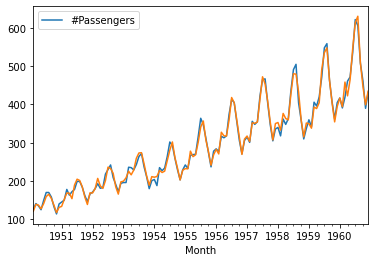

In [19]:
order = scores[0][0][0]
sorder = scores[0][0][1]
trend = scores[0][0][2]

model = SARIMAX(no_variance, order=order, seasonal_order=sorder, trend=trend)
model_fit = model.fit(disp=0)
predsarima = np.exp(model_fit.predict(sorder[-1]+1,dynamic=False))

ax = np.exp(no_variance[sorder[-1]+1:]).plot(label='observed')
predsarima.plot(label='One-step ahead Forecast', ax=ax)
plt.show()

It seems that the model is very precise. Finally, let's calculate the quality measures using also the script of the original Notebook.

In [20]:
def forecast_accuracy(actual, forecast):
    actual = np.squeeze(actual)
    forecast = np.squeeze(forecast)
    mse = mean_squared_error(actual, forecast)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE                     
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'mse': mse})

#print('ARIMA')
#stats = forecast_accuracy(np.exp(ts_noincreasingvar[sorder[-1]+1:].values), predarima.values)
#for key in stats.keys():
#    print(key,': \t',stats[key])

print('SARIMA')
stats = forecast_accuracy(np.exp(no_variance[sorder[-1]+1:].values), predsarima.values)
for key in stats.keys():
    print(key,': \t',stats[key])

SARIMA
mape : 	 0.029535415099529734
me : 	 -0.13647532090291423
mae : 	 8.24694709758719
mpe : 	 -0.0004342311044735234
rmse : 	 10.869527285489319
mse : 	 118.14662340999679


### Final results.

These results are very similar to the results we got using the another model candidate: SARIMA: (1, 1, 1), (2, 1, 0, 12).

The original Notebook has the following results using SARIMA model (ARIMA model does not matter here because its accuracy is worse than SARIMA's one).

SARIMA  
* mape : 	 0.05124427374246154  
* me : 	 -2.7283999934355623  
* mae : 	 13.506225574737927  
* mpe : 	 -0.021322375695832792  
* rmse : 	 17.00474716753212  
* mse : 	 289.1614262316916  

We have decreased all these error measures using either of these models:

SARIMA: (p,d,q) = (0, 1, 1), (P,D,Q) = (2, 1, 0, 12), trend = n,  
SARIMA: (p,d,q) = (1, 1, 1), (P,D,Q) = (2, 1, 0, 12), trend = n,  

We can say that we have improved a bit the original results and our model is better ! Task completed !